In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

Which specific segment are we aiming to forecast?

First we read the data the earning per share of Johnson & Johnson

In [3]:
file_path = "./datasets/jj.csv"
df = pd.read_csv(file_path, parse_dates=[0])
df


,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


Add some area to the segment that we want to forecast.

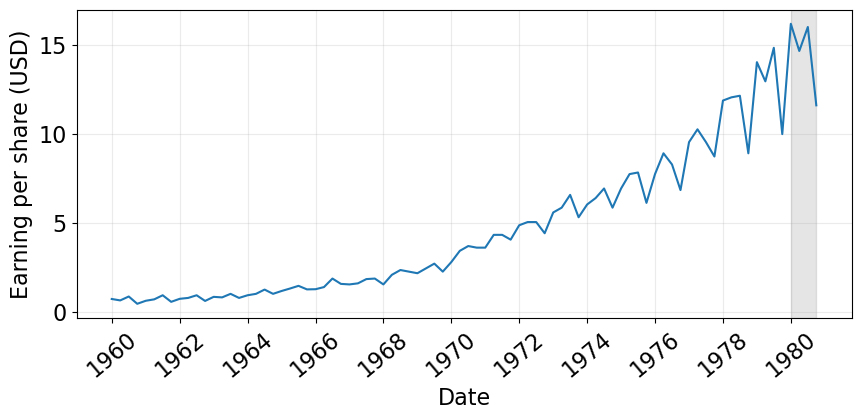

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))

x_year = pd.DatetimeIndex(df["date"]).year
ax.plot(df["date"], df["data"])

# add forecast area
ax.axvspan(
  np.datetime64("1980-01"),
  np.datetime64("1980-10"),  # the last data point in `data`
  color="#808080", alpha=0.2
)

formatter = mdates.DateFormatter("%Y")
locator = mdates.YearLocator(base=2)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Earning per share (USD)")

for label in ax.get_xticklabels():
  label.set_rotation(40)
  # label.set_horizontalalignment('right')
plt.show(fig)


## 2.1 Defining a baseline model

**Baseline model**     
A baseline model is a trivial solution to your forecasting problem. 
It relies on heuristics or simple statistics and is usually 
the simplest solution. It does not require model fitting, and it 
is easy to implement.

There are three possible baseline models

- (mean): The average EPS between 1960 and 1979 was $4.31. 
  Therefore, 
  I expect the EPS over the next four quarters of 1980 to be 
  equal to $4.31 per quarter

- (last recorded): If the EPS if $0.71 for this quarter,
  then the EPS will also be $0.71 for next quarter.

- (naive seasonal): If the EPS is $14.04 for the first quarter of
  1979, then the EPS for the first quarter of 1980 will also
  be $14.04

## 2.2 Forecasting the historical mean

Split the data into `train` and `test`.

In [5]:
train = df[:-4].copy()
test = df[-4:].copy()   # Take the last four points as our ground truth

display(train)
display(test)

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
75,1978-10-01,8.91
76,1979-01-01,14.04
77,1979-04-02,12.96
78,1979-07-02,14.85


,date,data
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02
83,1980-10-01,11.61


In [6]:
historical_mean = np.mean(train["data"])
print(f"{historical_mean:.2f}")

# using : in the first axis of test data, won't work
# and give `SettingWithCopyWarning!`
test["pred_mean"] = historical_mean
display(test)

4.31


,date,data,pred_mean
80,1980-01-01,16.20,4.3085
81,1980-04-01,14.67,4.3085
82,1980-07-02,16.02,4.3085
83,1980-10-01,11.61,4.3085


MAPE (Mean Absolute Percentage Erro)

$$
\textrm{MAPE}
  = \frac{1}{n} \sum_{i=1}^n 
    \left|
      \frac{A_i - F_i}{A_i}
    \right| \times 100
$$

where $A_i$ is the actual value at point $i$ in time,
and $F_i$ is the forecast value at point $i$ in time;
$n$ is simply the number of forecasts.

In [7]:
def mape(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Calculate the MAPE for the first baseline (historical mean)


In [12]:
mape_hist_mean = mape(test["data"], test["pred_mean"])
print(f"{mape_hist_mean:.2f}%")

70.01%


Visualizing the forecasts

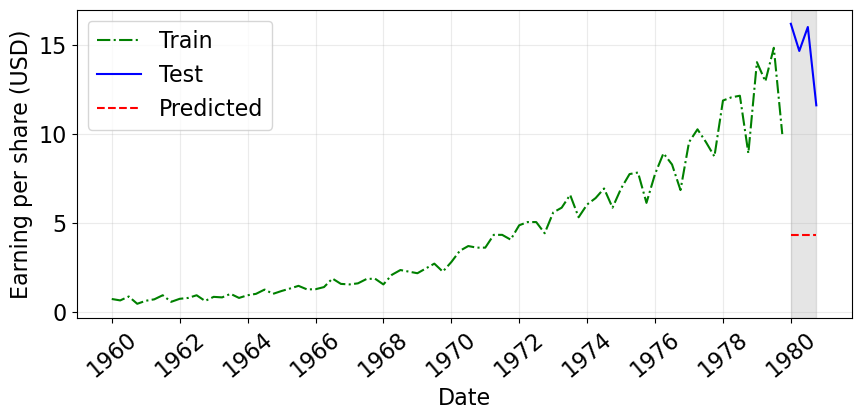

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))

x_year = pd.DatetimeIndex(df["date"]).year

ax.plot(train["date"], train["data"], "g-.", label="Train")
ax.plot(test["date"], test["data"], "b-", label="Test")
ax.plot(test["date"], test["pred_mean"], "r--", label="Predicted")

# add forecast area
ax.axvspan(
  np.datetime64("1980-01"),
  np.datetime64("1980-10"),  # the last data point in `data`
  color="#808080", alpha=0.2
)

formatter = mdates.DateFormatter("%Y")
locator = mdates.YearLocator(base=2)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Earning per share (USD)")
ax.legend(loc="upper left")

for label in ax.get_xticklabels():
  label.set_rotation(40)
  # label.set_horizontalalignment('right')

plt.show(fig)

## 2.3 Foreacsting last year's mean

Compute the average EPS for the four quarters of 1979, which are the last
four data points of the train set.

In [29]:
last_year_mean = np.mean(train.data[-4:])
print(f"{last_year_mean:.2f}")

12.96


In [30]:
test["pred_last_year_mean"] = last_year_mean
test

,date,data,pred_mean,pred_last_year_mean,pred_last,pred_last_season
80,1980-01-01,16.20,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,4.3085,12.96,9.99,12.96
82,1980-07-02,16.02,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99,9.99


In [31]:
mape_last_year_mean = mape(test["data"], test["pred_last_year_mean"])
print(f"{mape_last_year_mean:.2f}%")

15.60%


In [32]:
def plot_prediction(model="pred_mean"):
  fig, ax = plt.subplots(figsize=(10, 4))

  x_year = pd.DatetimeIndex(df["date"]).year

  ax.plot(train["date"], train["data"], "g-.", label="Train")
  ax.plot(test["date"], test["data"], "b-", label="Test")
  ax.plot(test["date"], test[model], "r--", label="Predicted")

  # add forecast area
  ax.axvspan(
    np.datetime64("1980-01"),
    np.datetime64("1980-10"),  # the last data point in `data`
    color="#808080", alpha=0.2
  )

  formatter = mdates.DateFormatter("%Y")
  locator = mdates.YearLocator(base=2)
  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)

  ax.grid("on")
  ax.set_xlabel("Date")
  ax.set_ylabel("Earning per share (USD)")
  ax.legend(loc="upper left")

  for label in ax.get_xticklabels():
    label.set_rotation(40)
    # label.set_horizontalalignment('right')

  plt.show(fig)


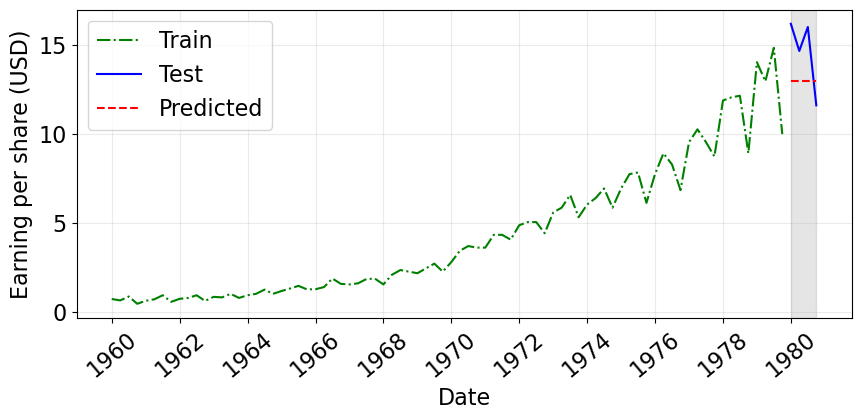

In [33]:
plot_prediction("pred_last_year_mean")

## 2.4 Predicting using the last known value

In [34]:
last = train.data.iloc[-1]
print(last)

9.99


In [35]:
test["pred_last"] = last
test

,date,data,pred_mean,pred_last_year_mean,pred_last,pred_last_season
80,1980-01-01,16.20,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,4.3085,12.96,9.99,12.96
82,1980-07-02,16.02,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99,9.99


In [36]:
mape_last = mape(test["data"], test["pred_last"])
print(f"{mape_last:.2f}%")

30.46%


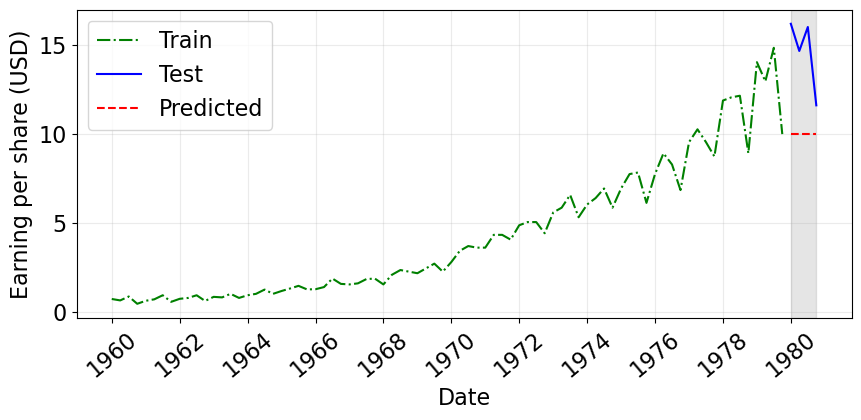

In [37]:
plot_prediction("pred_last")

## 2.5 Implementing the naive seasonal forecast

In [38]:
test["pred_last_season"] = train["data"][-4:].values
test

,date,data,pred_mean,pred_last_year_mean,pred_last,pred_last_season
80,1980-01-01,16.20,4.3085,12.96,9.99,14.04
81,1980-04-01,14.67,4.3085,12.96,9.99,12.96
82,1980-07-02,16.02,4.3085,12.96,9.99,14.85
83,1980-10-01,11.61,4.3085,12.96,9.99,9.99


In [39]:
mape_naive_seasonal = mape(test["data"], test["pred_last_season"])
print(f"{mape_naive_seasonal:.2f}%")

11.56%


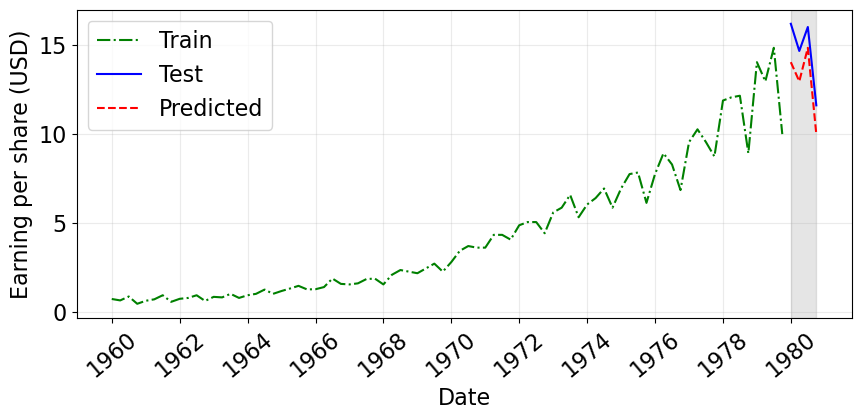

In [40]:
plot_prediction("pred_last_season")

## 2.6 Next steps

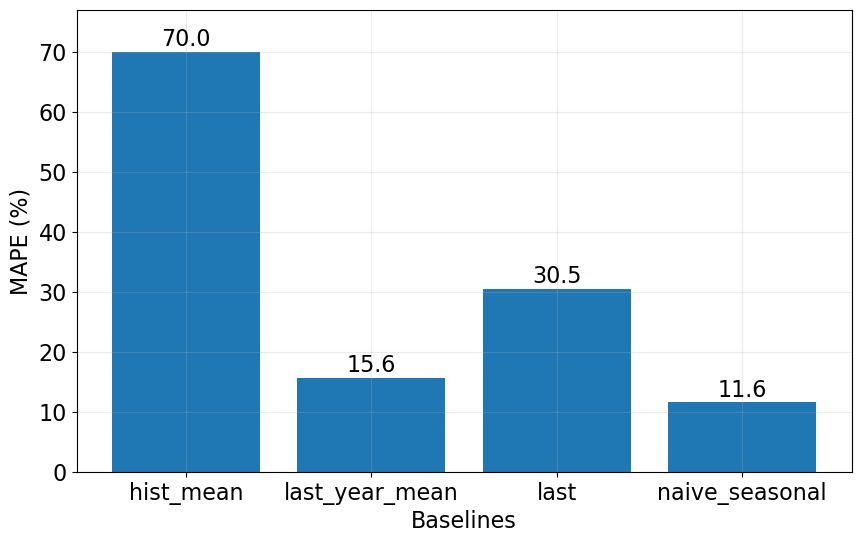

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))

x_array = ["hist_mean", "last_year_mean", "last", "naive_seasonal"]
y_array = [mape_hist_mean, mape_last_year_mean, mape_last, mape_naive_seasonal]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Baselines")
ax.set_ylabel("MAPE (%)")
ax.set_ylim([0., 77])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+1, s=f"{val:.1f}", ha="center")

plt.show(fig)

In [42]:
test[x_array]

KeyError: "None of [Index(['hist_mean', 'last_year_mean', 'last', 'naive_seasonal'], dtype='object')] are in the [columns]"